In [1]:
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_fixtures.jl")
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_visuals.jl")
import jcontrol as jc
using Printf


  Activating project at `~/Documents/Github/LocomotionControl/analysis/behavior`


@Info (Main):  Loaded 1021 trials 
  ╰──────────────────────────────────────────────── 


                      Wed, 04 May 2022 16:49:52 
@Info (Main):  After tortuosity analysis, discarded 9.109% of trials | 928

 
  │                trials left 
  ╰──────────────────────────────────────────────── 
                      Wed, 04 May 2022 16:49:56 


## MTM multiple horizons
Analyze MTM simulations at curves using multiple horizons.

Start by loading MTM simultions.

In [3]:
function make_palette(x)
    return range(HSL(217, .64, .55), stop=HSL(320, .73, .78), length=length(x))
end


function get_startstop(solution, curve)
    start = findfirst(solution.s .>= curve.s0)
    stop = findfirst(solution.s .>= curve.sf)
    stop = isnothing(stop) ? argmax(solution.s) : stop

    complete = solution.s[stop] > (curve.sf - 1)
    return start, stop, complete
end

get_startstop (generic function with 1 method)

In [37]:
globalsolution = load_global_solution()

path = "/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/horizons_mtm_sims"

# load individual solutions
files = sort(glob("*.csv", path), lt=natural)

curves_solutions = Dict(
    1=>Dict{String,Any}(), 2=>Dict{String,Any}(), 3=>Dict{String,Any}(), 4=>Dict{String,Any}()
)


s2curvidx = Dict(
    0=>1, 45=>2, 98=>3, 15=>4
)

for file in files[2:end]
    fname = string(splitext(basename(file))[1])
    s = fname[5] != '.' ? parse(Int, fname[4:5]) : 0
    curve = s2curvidx[s]

    if curve == 1
        horizon = fname[24:27]
    elseif curve == 4 
        horizon = fname[26:29]
    else
        horizon = fname[25:28]
    end

    sol  = df2sol(DataFrame(CSV.File(file)))
    curves_solutions[curve][horizon] = sol
end

for (k,v) in pairs(curves_solutions)
    println("Curve $k, loaded $(length(v))")
end


## Tracking plots. 

Plot for each solution at each curve the XY coordinates of the trajectory, marking where it ends.

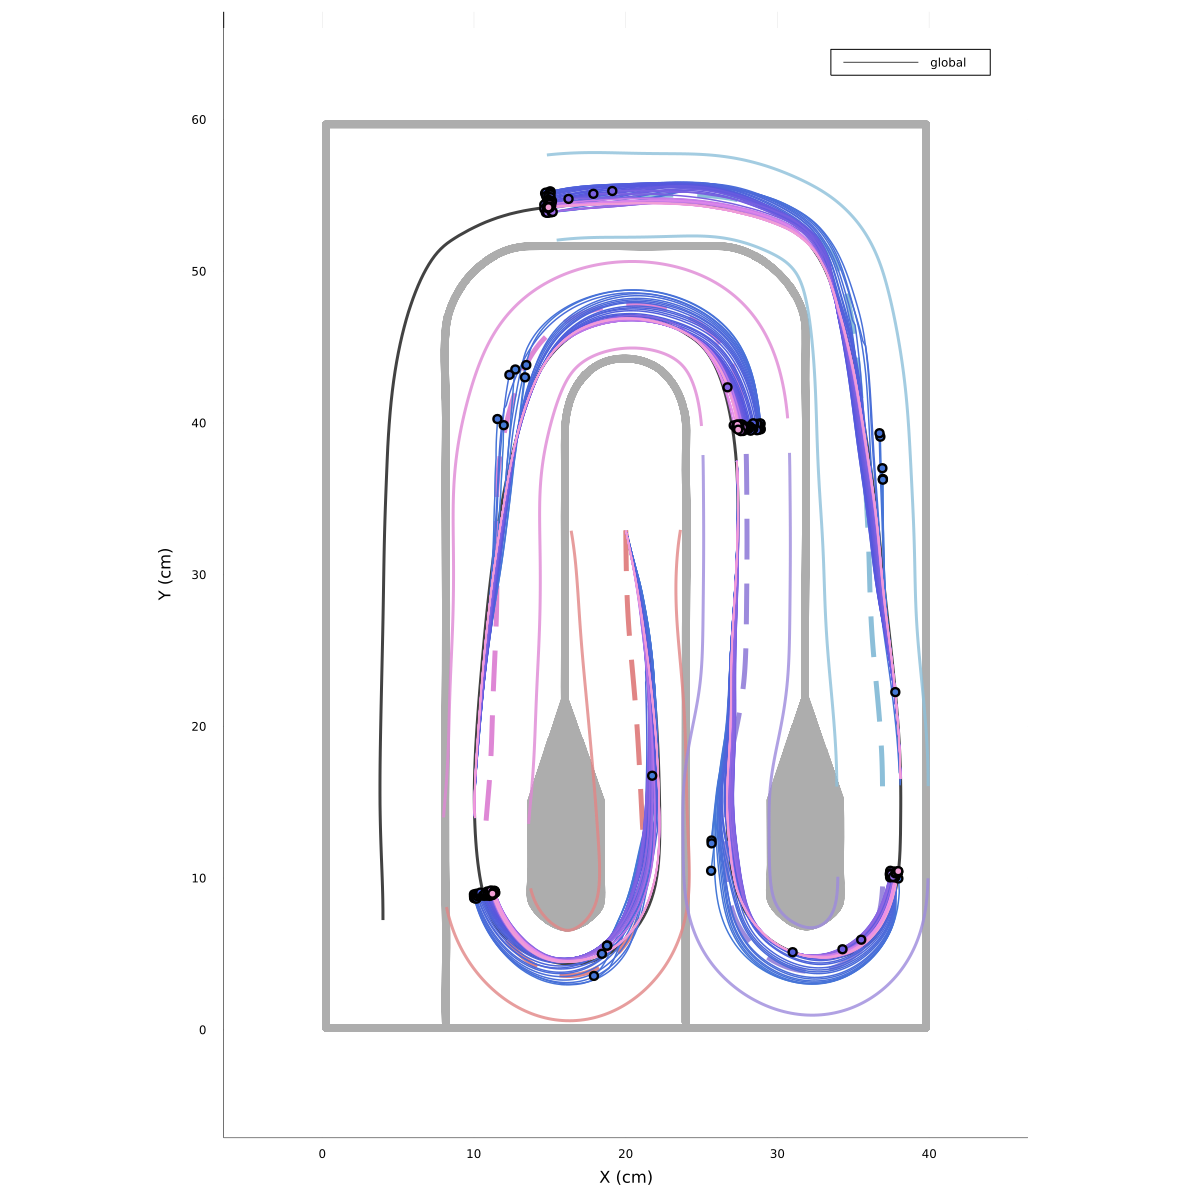

In [42]:
# plot XY traj
_horizons = .08:.01:1.2
_colors = make_palette(_horizons)
colors = Dict(string(@sprintf("%.2f", h))=>c for (h,c) in zip(_horizons, _colors))


plt = draw(:arena)

# draw!.(trials[1:200])
plot!(globalsolution.x, globalsolution.y, label="global", color=grey_darker, lw=3)

for k in 1:4
    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curves_solutions[k])))

    # draw curve
    track = jc.trim(FULLTRACK, curve.s0, curve.sf-curve.s0)
    draw!(track, color=curves_colors[k], Δp=50, alpha=1)

    # plot XY traj
    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        start, stop, complete = get_startstop(solution, curve)
        plot!(solution.x[start:stop], solution.y[start:stop], label=nothing, color=color, lw=1.5)
        
    end

    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        start, stop, complete = get_startstop(solution, curve)
        scatter!([solution.x[stop]], [solution.y[stop]], label=nothing, color=color, ms=5)
    end
end

savefig(joinpath(PLOTS_FOLDER, "horizons_XY.svg"))
plt

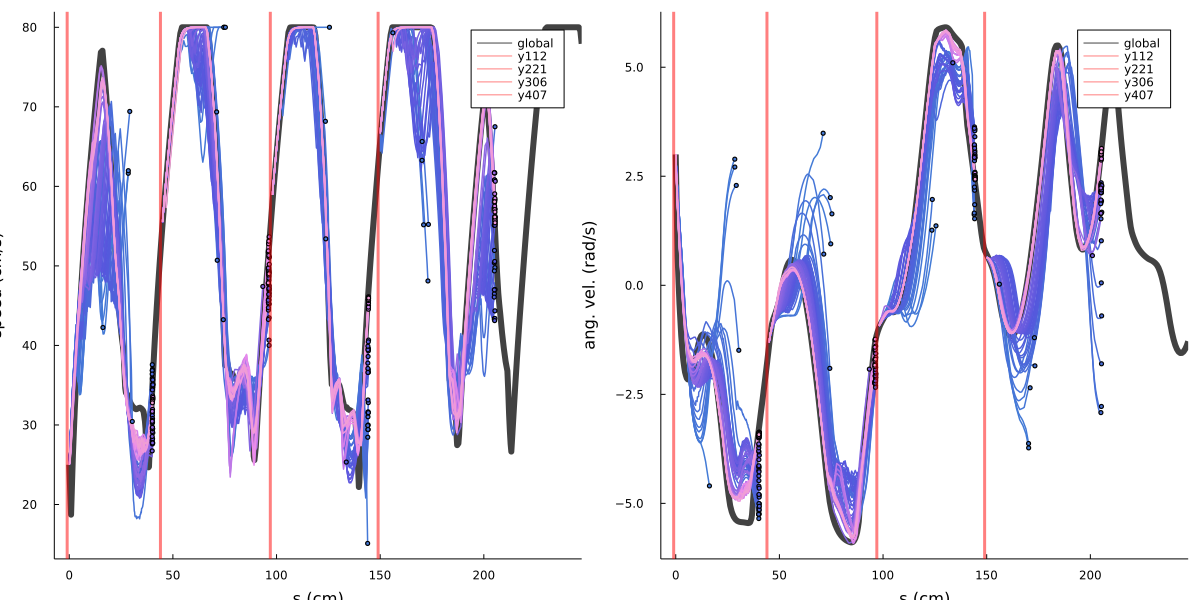

In [5]:
# plot linearized kinematics of all solutions

uplot = plot(; size=(1200, 400), xlim=[0, 240], xlabel="s (cm)", ylabel="speed (cm/s)")
plot!(globalsolution.s, globalsolution.u, label="global", color=grey_darker, lw=6)

oplot = plot(; size=(1200, 400), xlim=[0, 240], xlabel="s (cm)", ylabel="ang. vel. (rad/s)")
plot!(globalsolution.s, globalsolution.ω, label="global", color=grey_darker, lw=6)

for k in 1:4
    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curves_solutions[k])))

    # plot XY traj
    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        start, stop, complete = get_startstop(solution, curve)
        plot!(uplot, solution.s[start:stop], solution.u[start:stop], label=nothing, color=color, lw=1.5)
        plot!(oplot, solution.s[start:stop], solution.ω[start:stop], label=nothing, color=color, lw=1.5)
    end

    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        start, stop, complete = get_startstop(solution, curve)
        scatter!(uplot, [solution.s[stop]], [solution.u[stop]], label=nothing, color=color, ms=3)
        scatter!(oplot, [solution.s[stop]], [solution.ω[stop]], label=nothing, color=color, ms=3)
    end

    vline!(uplot, [curve.s0-1], color="red", alpha=.5, lw=3)
    vline!(oplot, [curve.s0-1], color="red", alpha=.5, lw=3)
end

plot(uplot, oplot; grid=false, size=(1200, 600))

### plot duration of each simulation

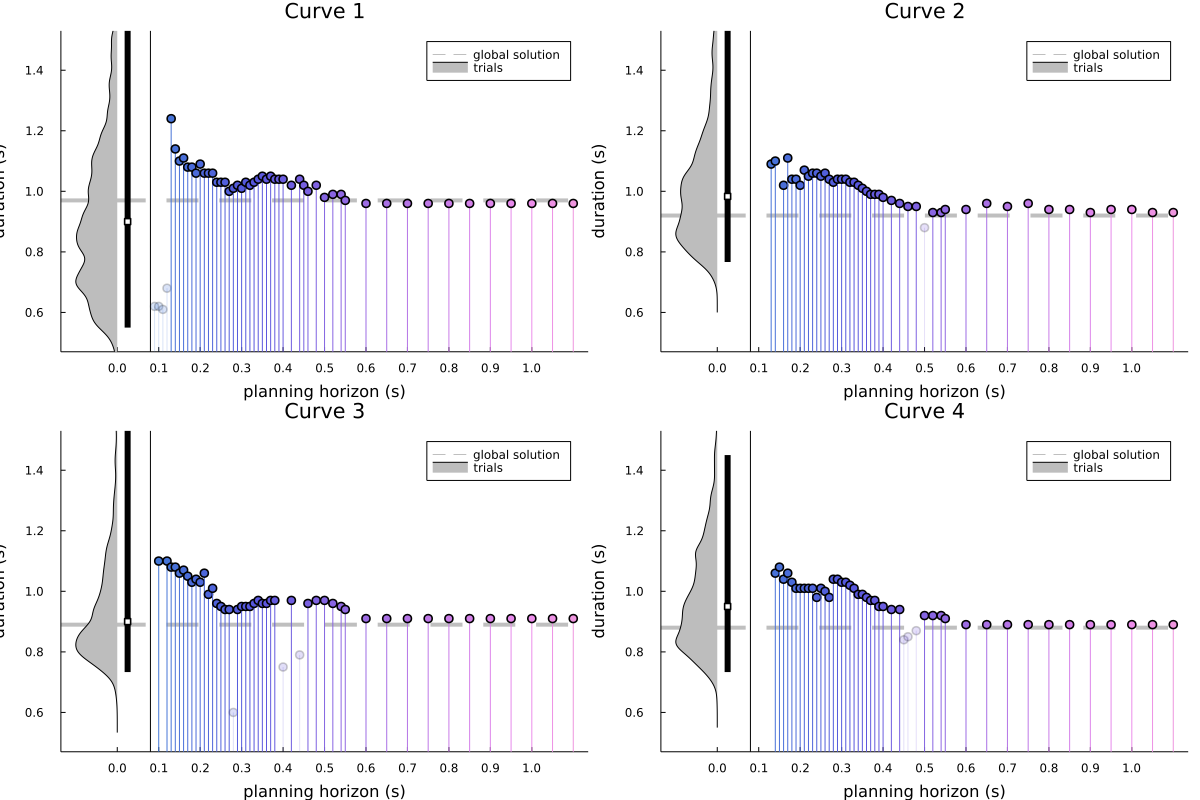

In [43]:
plots = []

Δt=.01  # step size used for simulations
T0 = 0
for k in 1:4
    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curves_solutions[k])))

    plt = plot(; xlabel="planning horizon (s)", ylabel="duration (s)", ylim=[0.5, 1.5], xlim=[-.1, 1.1], title="Curve $k", xticks=0.0:.1:1)

    # plot duration for globalsolution
    start, stop, complete = get_startstop(globalsolution, curve)
    hline!([(stop-start)*globalsolution.δt], lw=4, color="black", alpha=.25, ls=:dash, label="global solution")

    # mark min/max horizons
    vline!(
        [parse(Float64, horizons[1]), parse(Float64, horizons[end])], color="black", label=nothing
    )

    # plot duration of each sim
    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        start, stop, complete = get_startstop(solution, curve)
        alpha = complete ? 1.0 : 0.2

        duration = (stop-start)  * Δt

        h = parse(Float64, horizon)
        # vline!([h], lw=.5, color="black", label=nothing)
        plot!(plt, [h, h], [T0, duration], label=nothing, color=color, alpha=alpha, lw=1)
        scatter!(plt, [h], [duration], label=nothing, color=color, alpha=alpha, ms=5)
    end


    # plot KDE with durations of each trial
    trial_durations = []
    for trial in trials
        _, _, start, stop = get_curve_indices(trial, curve.s0, curve.sf)
        push!(trial_durations, (stop-start) / 60)
    end
    B = kde(Vector{Float64}(trial_durations); bandwidth=.025)
    plot!(
        -B.density ./ max(B.density...) .* .1 , B.x;
        color="black",
        fillalpha=1,
        fillcolor=grey,
        fillrange=zeros(length(B.density)),
        label="trials"
    )
    low, med, high = percentile(trial_durations, [2.5, 50, 97.5])
    plot!(
        [0.025, 0.025], [low, high], lw=6, color="black", alpha=1, label=nothing
    )
    scatter!([0.025], [med], label=nothing, color="white", ms=3, shape=:rect)


    push!(plots, plt)
end


fig = plot(plots...; grid=false, link=:all, size=(1200, 800))
savefig(joinpath(PLOTS_FOLDER, "horizons_duration.svg"))

fig

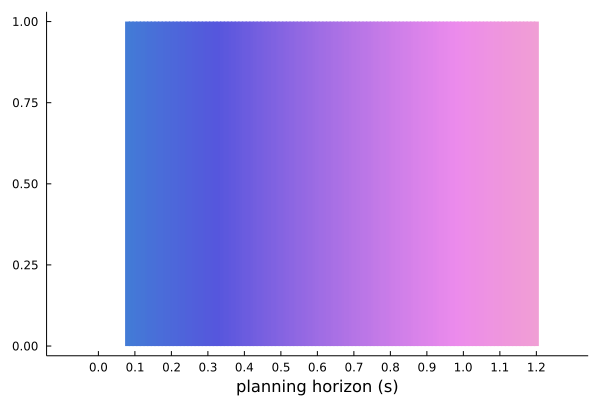

In [44]:
# plot colors to make "colorbar"

plt = plot(; xlabel="planning horizon (s)",ylim=[0, 1], xlim=[-.1, 1.3], grid=false, xticks=0.0:.1:1.2)


for (h,c) in pairs(colors)
    h = parse(Float64, h)

    plot!(plt, [h, h], [0, 1], label=nothing, color=c, lw=5)

end

savefig(joinpath(PLOTS_FOLDER, "horizons_cbar.svg"))

plt


### Compare XY trajectories

In [28]:
import jcontrol: interpolate_wrt_to
using Interpolations

# itp = LinearInterpolation(data[:,1], data[:,2])

function get_pos(solution, S, var;  stop=nothing)
    stop = isnothing(stop) ? length(solution.s) : stop
    
    _s = solution.s[1:stop]
    _x = getfield(solution, var)[1:stop]

    # x = interpolate_wrt_to(_s, _x)
    itp = LinearInterpolation(_s, _x, extrapolation_bc=Flat())
    return itp.(S)
end

get_pos (generic function with 1 method)

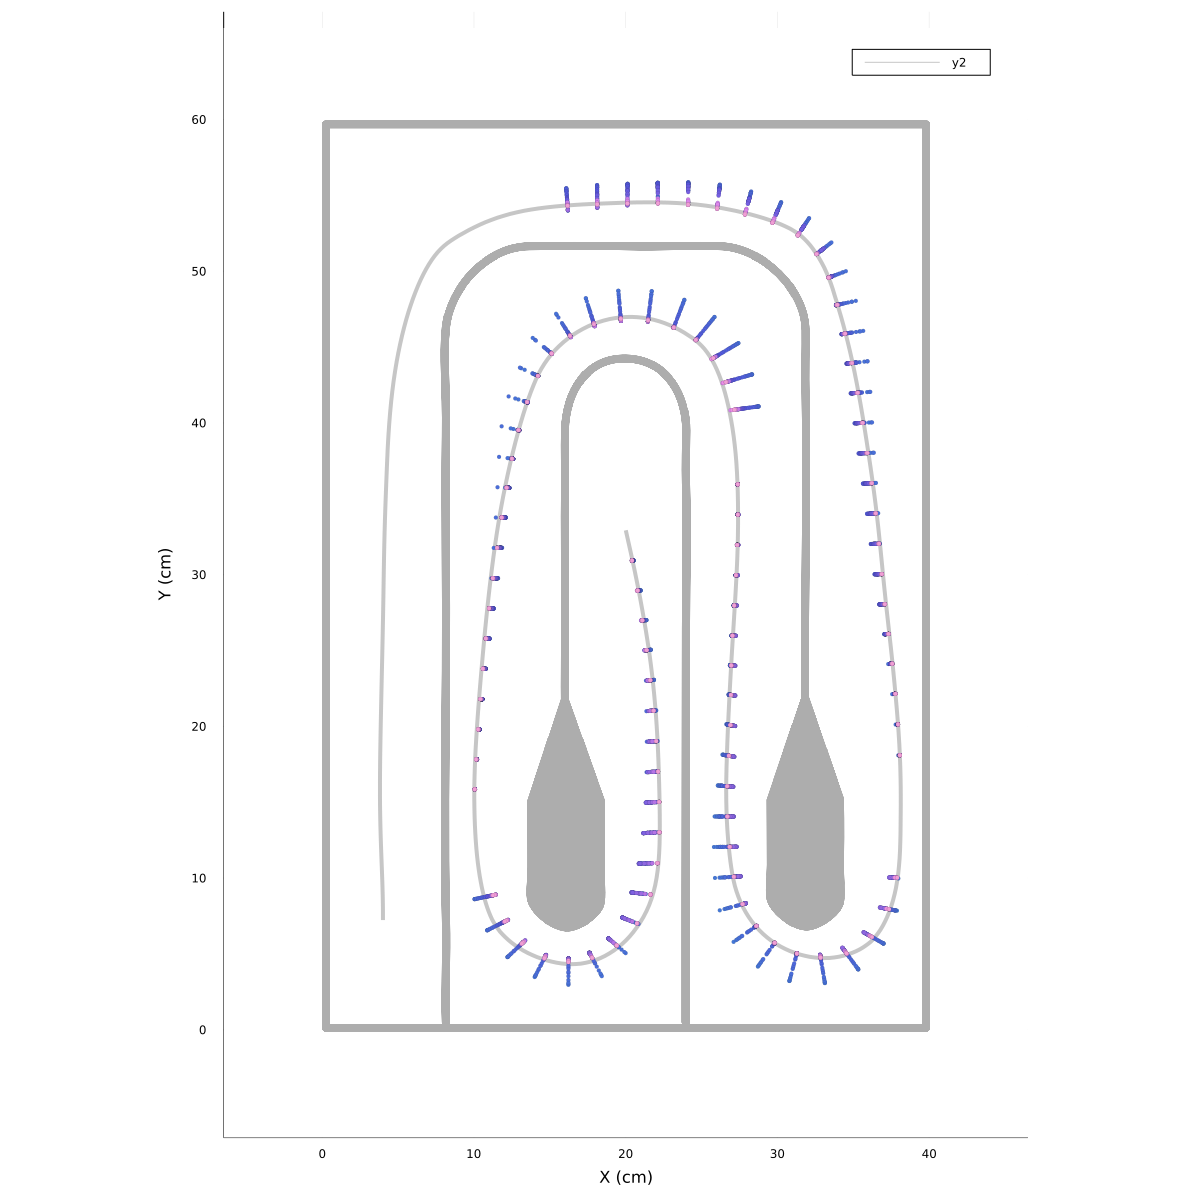

In [45]:


fig = draw(:arena)

plot!(
    globalsolution.x, globalsolution.y, color=grey_darker, lw=4, alpha=.3
)

distances = []
for k in 1:4
    plt = plot() 

    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curves_solutions[k])))
    curve_distances = Dict{String, Vector{Float64}}(h=>[-100.0] for h in horizons)


    S = collect(curve.s0+2:2:curve.sf)

    gs_x = get_pos(globalsolution, S, :x)
    gs_y = get_pos(globalsolution, S, :y)
    # scatter!(fig, gs_x, gs_y, label=nothing, color="black", ms=4)

    # mark each solution
    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        
        start, stop, complete = get_startstop(solution, curve)
        complete || continue

        x, y = get_pos(solution, S, :x; stop=stop), get_pos(solution, S, :y; stop=stop)

        if any(isnan.(x)) || any(isnan.(y))
            throw("caca")
        end

        # keep distances
        curve_distances[horizon] = sqrt.((gs_x .- x).^2 + (gs_y .- y).^2)

        scatter!(fig, x, y, label=nothing, color=color, ms=2.5, msw=0.0)
    end
    push!(distances, curve_distances)
end

savefig(joinpath(PLOTS_FOLDER, "horizons_XY_scatter.svg"))
fig

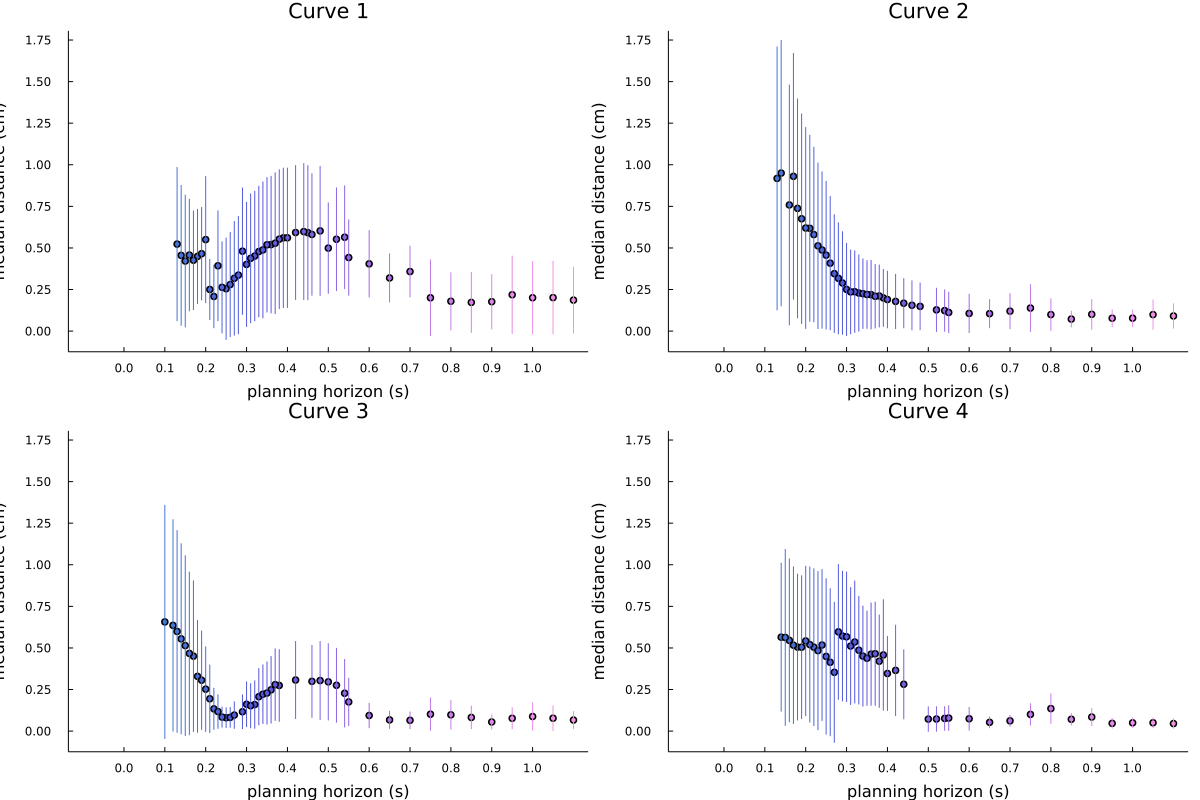

In [46]:
plots = []
for k in 1:4
    plt = plot(; xlabel="planning horizon (s)", ylabel="median distance (cm)", xlim=[-.1, 1.1], title="Curve $k", xticks=0.0:.1:1, yticks=0:.25:2.0)

    # get data
    curve = curves[k]
    curve_distances = distances[k]
    horizons = sort(collect(keys(curve_distances)))

    for (h, d) in pairs(curve_distances)
        d[1] == -100.0 && continue
        d̄ = mean(d)
        low, high = -std(d) + d̄, std(d) + d̄

        color = colors[h]
        h = parse(Float64, h)

        scatter!(plt, [h], [d̄], label=nothing, color=color, ms=4)
        plot!(plt, [h, h], [low, high], label=nothing, color=color, lw=1)
    end

    push!(plots, plt)
end

fig = plot(plots...; grid=false, link=:all, size=(1200, 800))
savefig(joinpath(PLOTS_FOLDER, "horizons_distances.svg"))
fig

### Make plot

calcspeed(solution, idx) = sqrt.(solution.u[idx] .^ 2 .+ solution.v[idx] .^ 2)


# get solution kinematics at control points
struct Kinematics
    s::Vector{Number}
    speed::Vector{Number}
    ω::Vector{Number}
    planning_window::Float64
    duration::Float64
    valid::Bool
end

function Kinematics(solution, points, planning_window)
    valid = true
    solution.s[end] < 258 && begin
        # println("Solution (window:$planning_window) ends before end of track")
        valid = false
    end

    svals, s, ω = [], [], []
    for p in points
        idx = findfirst(solution.s .>= p.s)
        isnothing(idx) && begin
            println("Solution $planning_window stops before $(p.s)")
            valid = false
            break
        end

        push!(s, calcspeed(solution, idx))
        push!(ω, solution.ω[idx])
        push!(svals, p.s)
    end

    planning_window = planning_window isa AbstractString ? parse(Float64, planning_window) : planning_window
    return Kinematics(svals, s, ω, planning_window, solution.t[end], valid)
end

# get kinematics MSE wrt to global solution
struct MSE
    speed::Float64
    ω::Float64
    planning_window::Float64
    s::Float64
end

function MSE(globalsolution::Kinematics, solution::Kinematics)
    @assert length(solution.s) == length(globalsolution.s)
    return MSE(
        mean((globalsolution.speed .- solution.speed).^2),
        mean((globalsolution.ω .- solution.ω).^2),
        solution.planning_window,
        0.0
    )
end


pts = cpoints.points[4:end-1]

gs_kinematics = Kinematics(globalsolution, pts, 100.1);
all_solutions_kinematics = map(s -> Kinematics(s[1], pts, s[2]), zip(solutions, _names))

# keep only valid solutions
solutions_kinematics = filter(k -> k.valid, all_solutions_kinematics)
@info "Got $(length(solutions_kinematics)) solution kinematics  (out of $(length(files)) files)" length(all_solutions_kinematics)

MSEs = map(kin -> MSE(gs_kinematics, kin), solutions_kinematics);

colors = range(HSL(326, .9, .68), stop=HSL(212, .9, .6), length=max(2, length(MSEs)))
alphas = range(.9, .6, length=max(5, length(MSEs)));


layout = @layout [
    a{1.0h} grid(2, 1){.7w, 1.0h} 
    c{.2h}
    d{.5h} e{.5h}
]

fig = plot(; layout=layout, size=(1000, 800))


plot!(
    globalsolution.x, globalsolution.y,
    lw=4, color=blue_grey_darker, label=nothing, subplot=1,
    aspect_ratio=:equal, xlim=[-5, 45], ylim=[-5, 65]
)

# plot global solution kinematics at checkpoints
# for cp in cpoints.points[2:end-1]
#     idx = findfirst(globalsolution.s .>= cp.s)
#     scatter!(
#         [globalsolution.s[idx]], [√(globalsolution.u[idx]^2 + globalsolution.v[idx]^2)],
#         color=blue_grey_darker, label=nothing, subplot=2, ms=8, msw=0
#     )

#     scatter!(
#         [globalsolution.s[idx]], [globalsolution.ω[idx]],
#         color=blue_grey_darker, label=nothing, subplot=3, ms=8, msw=0
#     )
# end

plot!(
    globalsolution.s, sqrt.(globalsolution.u .^ 2 .+ globalsolution.v .^ 2),
    lw=4, color=blue_grey_darker, label=nothing, subplot=2,
)
plot!(
    globalsolution.s, globalsolution.ω,
    lw=4, color=blue_grey_darker, label=nothing, subplot=3,
)


# plot trials durations histogram
histogram!(
    getfield.(trials, :duration), 
    bins=25, 
    color="black", 
    subplot=4,
    colorbar=false, label=nothing,
)
plot!(
    [globalsolution.t[end], globalsolution.t[end]], [0, 300], subplot=4,
    lw=4, color=salmon, alpha=1.0, label=nothing
)

# plot individual solutions 
for (n, (solution, color, alpha)) in enumerate(zip(solutions, colors, alphas))
    # plot XY trajectory
    plot!(
        solution.x, solution.y, color=color, subplot=1, label=nothing, lw=2, alpha=alpha
    )


    # plot kinematics
    for cp in cpoints.points[2:end-1]
        idx = findfirst(solution.s .>= cp.s)
        isnothing(idx) && continue
        scatter!(
            [solution.s[idx]], [√(solution.u[idx]^2 + solution.v[idx]^2)],
            color=color, label=nothing, subplot=2, ms=3.4, msw=0
        )
    
        scatter!(
            [solution.s[idx]], [solution.ω[idx]],
            color=color, label=nothing, subplot=3, ms=3.4, msw=0
        )
    end

#     plot!(
#         solution.s, sqrt.(solution.u .^ 2 .+ solution.v .^ 2), color=color, subplot=2, label=nothing, lw=3, alpha=alpha
#     )
#     plot!(
#         solution.s, solution.ω, color=color, subplot=3, label=nothing, lw=3, alpha=alpha
#     )
end

# plot solutions durations
for (n, kin) in enumerate(solutions_kinematics)
    plot!(
        [kin.duration, kin.duration], [0, 50 + 10n], subplot=4,
        lw=2, color=colors[n], alpha=1, label=nothing
    )
end


# plot MSEs
for i in 1:length(MSEs)
    ms = MSEs[i]
    plot!(
        [ms.planning_window, ms.planning_window],
        [0, ms.speed],
        color=colors[i], lw=2, subplot=5, label=nothing
    )
    scatter!(
        [ms.planning_window],
        [ms.speed],
        color=colors[i],  subplot=5, label=ms.planning_window,
    )

    plot!(
        [ms.planning_window, ms.planning_window],
        [0, ms.ω],
        color=colors[i], lw=2, subplot=6, label=nothing
    )
    scatter!(
        [ms.planning_window],
        [ms.ω],
        color=colors[i],  subplot=6, label=nothing,
    )
end
# scatter!(
#     getfield.(MSEs, :planning_window),
#     getfield.(MSEs, :speed),
#     subplot=5, label=nothing
# )

# set plot properties
plot!(; subplot=2, xlim=[1, 250], xticks=[], ylabel="speed (cm/s)")
plot!(; subplot=3, ylim=[-15, 15], xlim=[1, 250], xlabel="distance (cm)", ylabel="angular velocity cm/s²")
plot!(; subplot=4, xlim=[0, 20], xlabel="duration (s)", ylabel="count")
plot!(; subplot=5, ylim=[-25, 200], xlim=[0, .5])
plot!(; subplot=6, ylim=[-1, 10], xlim=[0, .5])

display(fig)